### Import Libraries Needed

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

## Read the data and adjust

In [40]:
df = pd.read_csv("OrderDataForNTU.csv")

In [47]:
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197437 entries, 0 to 197436
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   UUID                    197437 non-null  object        
 1   TransactionNum          197437 non-null  object        
 2   TradesDate              197437 non-null  datetime64[ns]
 3   ChannelType             197437 non-null  object        
 4   ChannelDetail           197437 non-null  object        
 5   PaymentType             197437 non-null  object        
 6   ShippingType            197437 non-null  object        
 7   BeforeMemberTierLevel   197437 non-null  int64         
 8   AfterMemberTierLevel    197437 non-null  int64         
 9   TsCount                 197437 non-null  int64         
 10  Qty                     197437 non-null  int64         
 11  TotalSalesAmount        197437 non-null  int64         
 12  TotalPrice              197437

,UUID,TransactionNum,TradesDate,ChannelType,ChannelDetail,PaymentType,ShippingType,BeforeMemberTierLevel,AfterMemberTierLevel,TsCount,Qty,TotalSalesAmount,TotalPrice,TotalDiscount,TotalPromotionDiscount,TotalCouponDiscount,TotalLoyaltyDiscount,Status
0,U2131156,84GbV1FZLS+u1nu1FgX7AxmHsab=,2018-07-10,Pos,A039,Cash,Store,0,0,1,1,2380,2380,0,0,0,0,Finish
1,V02663974,g3sJev+nMFHCc7J+3MIkXaeA3wV=,2018-07-03,Pos,A042,Cash,Store,0,0,1,1,390,390,0,0,0,0,Finish
2,R03555577,jajyDU5zj3+0NFjBDzIPiijAdDD=,2018-07-04,Pos,A050,Cash,Store,0,0,1,1,1480,1480,0,0,0,0,Finish
3,O07191104,W5qdVNdgnsWEx8a7ikzHw/KbGI6=,2018-07-07,Pos,A051,Cash,Store,0,0,1,1,1380,1380,0,0,0,0,Finish
4,U99462295,zVBGf/pLjTKHQFQUEQ5zUTvS8Yp=,2018-07-08,Pos,A054,Cash,Store,0,0,1,1,1280,1280,0,0,0,0,Finish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197432,S94132783,ernGO9ZFEaaYsb5Nfz+n6SpePw8=,2018-11-07,OfficialECom,MobileWeb,SevenEleven,SevenEleven,0,0,10,10,9860,9860,0,0,0,0,Finish
197433,U2032035,zmR7XhtLmXhlUzU0rPIQbTIklSR=,2018-11-07,OfficialECom,iOSApp,SevenEleven,SevenEleven,0,0,10,10,7000,7200,-200,0,-200,0,Finish
197434,W0948255,EYbk8q+ZuQ/Trv5iUUW+yoQ8zlt=,2018-11-07,OfficialECom,iOSApp,SevenEleven,SevenEleven,0,0,10,10,7500,7700,-200,0,-200,0,Finish
197435,S06619015,g+AqzN8RF5TZ+qnxKDgLyEIthO6=,2018-11-07,OfficialECom,AndroidApp,SevenEleven,SevenEleven,0,0,10,10,9150,9350,-200,0,-200,0,Finish


In [42]:
df["TradesDate"] = pd.to_datetime(df["TradesDate"])    # Change the type of TradesDate to datetime format
df = df[~df["Status"].isin(["Return", "Cancel", "Overdue", "Fail"])].reset_index(drop = True)

In [43]:
max_date = df["TradesDate"].max()    # 2019-05-01 is the latest date

In [46]:
# Find the data with 1 year
df = df[(df["TradesDate"] <= max_date) & (df["TradesDate"] >= max_date - timedelta(days = 365))].reset_index(drop = True)

## Group the Data by UUID

In [53]:
# Get the Monetary data of member
tmp = df.groupby("UUID").sum().reset_index(drop = False)
tmp.sort_values(by = "TotalSalesAmount", ascending = False)

monetary = tmp[["UUID", "TotalSalesAmount"]]

In [56]:
# Get the Recency data of member
tmp = df.groupby("UUID").max().reset_index(drop = False)

last_purchase_date = tmp[["UUID", "TradesDate"]]

In [59]:
# Get the Frequency data of member
tmp = df.groupby("UUID").count().reset_index(drop = False)

order_count = tmp[["UUID", "TransactionNum"]]

In [63]:
# Merger three dataframe to RFM Model
RFM = pd.merge(pd.merge(monetary, last_purchase_date, on = "UUID"), order_count, on = "UUID")
RFM["Recency"] = max_date - RFM["TradesDate"]    # Subtract TradesDate with Max Date to figure out the days between two dates

In [90]:
# Use qcut to classify data
qcut_m = pd.qcut(RFM["TotalSalesAmount"], 5, labels = [1, 2, 3, 4, 5])    # Monetary

qcut_r = pd.qcut(RFM["Recency"], 5, labels = [5, 4, 3, 2, 1])    # Recency

qcut_f = pd.qcut(RFM["TransactionNum"].rank(method='first'), 5, labels = [1, 2, 3, 4, 5]) 

In [100]:
RFM_Model = pd.DataFrame()
RFM_Model["UUID"] = RFM["UUID"]
RFM_Model["Recency"] = qcut_r
RFM_Model["Frequency"] = qcut_f
RFM_Model["Monetary"] = qcut_m

In [101]:
RFM_Model

,UUID,Recency,Frequency,Monetary
0,N0002265,2,4,4
1,N0002329,4,3,4
2,N0002353,5,5,5
3,N0002364,3,4,3
4,N0002387,3,4,4
...,...,...,...,...
61308,X99966714,4,5,5
61309,X99971334,2,3,2
61310,X99983193,5,5,5
61311,X99992310,1,3,2


## Building RFM Model with K-means

In [104]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3)
kmeans.fit(RFM_Model[["Recency", "Frequency", "Monetary"]])

labels = kmeans.predict(RFM_Model[["Recency", "Frequency", "Monetary"]])

In [106]:
RFM_Model["Label"] = labels
RFM_Model

,UUID,Recency,Frequency,Monetary,Label
0,N0002265,2,4,4,2
1,N0002329,4,3,4,2
2,N0002353,5,5,5,2
3,N0002364,3,4,3,2
4,N0002387,3,4,4,2
...,...,...,...,...,...
61308,X99966714,4,5,5,2
61309,X99971334,2,3,2,1
61310,X99983193,5,5,5,2
61311,X99992310,1,3,2,1


## Draw the 3D plot of RFM Model

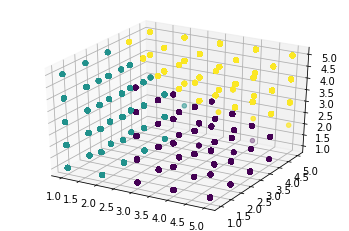

In [110]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(RFM_Model["Recency"], RFM_Model["Frequency"], RFM_Model["Monetary"], c = RFM_Model["Label"])

In [133]:
RFM["Subdate"] = RFM["Recency"].astype("str")
RFM["Subdate"] = RFM["Subdate"].str.split(" ")

In [139]:
for i in range(RFM["Subdate"].shape[0]):
    RFM["Subdate"][i] = RFM["Subdate"][i][0]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [148]:
RFM["Subdate"] = RFM["Subdate"].astype("int")

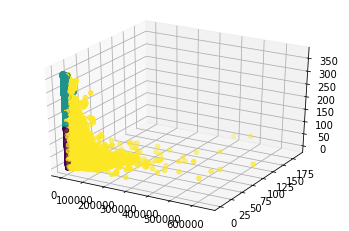

In [151]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(RFM["TotalSalesAmount"], RFM["TransactionNum"], RFM["Subdate"], c = RFM_Model["Label"])